Saving archive (3).zip to archive (3).zip
Dataset Loaded Successfully!

                             Patient_ID  Age     Sex Family_History  \
0  b2a49170-8561-4665-9371-2240b55dd87a   31    Male             No   
1  f5fae45d-8718-41c4-a957-6928f79f3c8e   33  Female            Yes   
2  66ab0567-050b-4d56-9ec4-b676309899a6   69    Male            Yes   
3  996a48e4-e841-418f-a539-5a7a86cd815d   66    Male            Yes   
4  d45c7ca8-7125-4aaa-8018-5bbc60d35a1f   43  Female            Yes   

   HTT_CAG_Repeat_Length Motor_Symptoms Cognitive_Decline  Chorea_Score  \
0                     67       Moderate            Severe          8.80   
1                     38         Severe          Moderate          3.24   
2                     37         Severe          Moderate          1.01   
3                     50           Mild            Severe          3.21   
4                     48       Moderate              Mild          2.31   

   Brain_Volume_Loss  Functional_Capacity  ... HTT

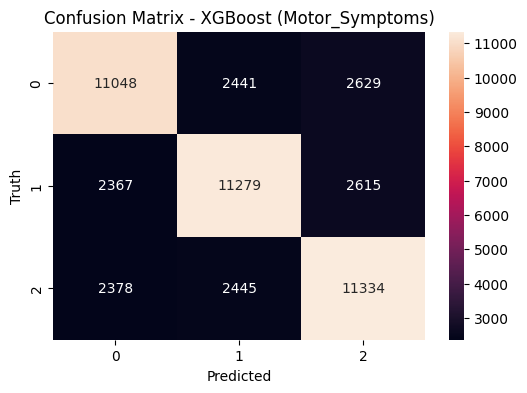


Training XGBoost for: Disease_Stage
Accuracy: 0.6450
Precision: 0.6454
Recall: 0.6450
F1 Score: 0.6450


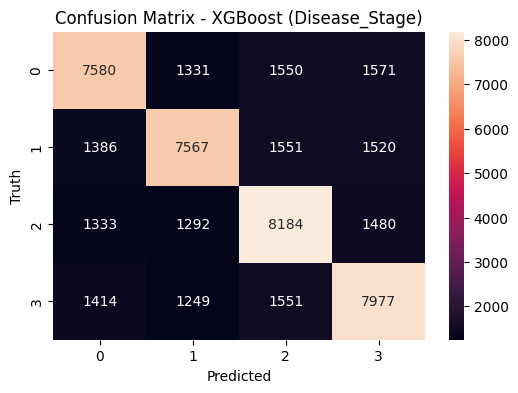


Training XGBoost for: Category
Accuracy: 0.6140
Precision: 0.7487
Recall: 0.6140
F1 Score: 0.5476


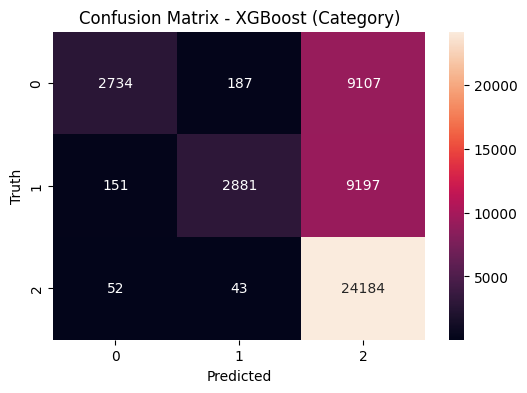


===== Comparison of Final Model Results =====
     Model          Target  Accuracy  Precision    Recall  F1 Score
0  XGBoost  Motor_Symptoms  0.693526   0.693661  0.693526  0.693529
1  XGBoost   Disease_Stage  0.645047   0.645412  0.645047  0.644990
2  XGBoost        Category  0.613957   0.748744  0.613957  0.547568

Per-Target Accuracy:
XGBoost - Motor_Symptoms: 69.35%
XGBoost - Disease_Stage: 64.50%
XGBoost - Category: 61.40%

Overall Dataset Accuracy (Average of all targets):
XGBoost: 65.08%


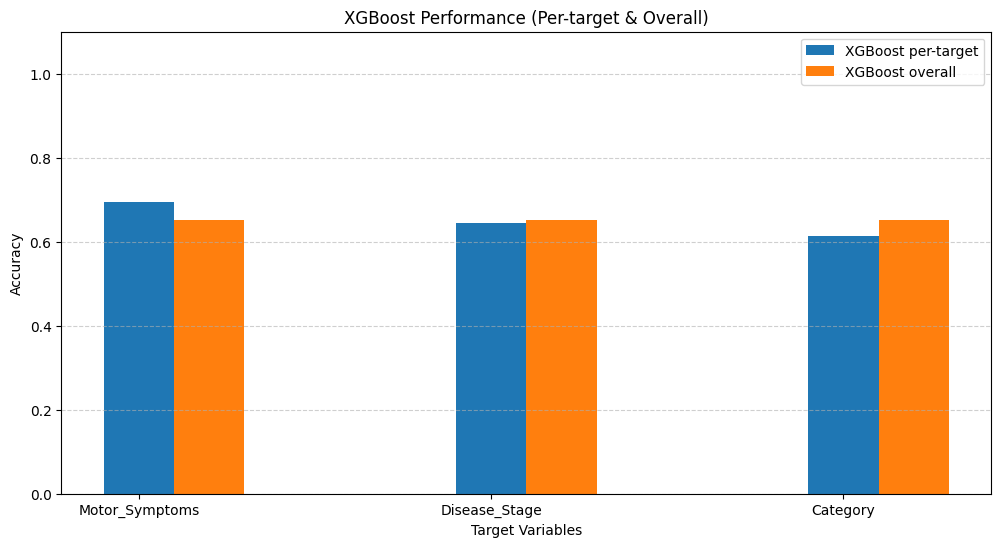

In [2]:
# libraries
import pandas as pd
import zipfile
import os
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import numpy as np

# install xgboost
!pip install -U xgboost

# upload and load dataset
uploaded = files.upload()
zip_filename = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    zip_ref.extractall("/content/")

extracted_files = os.listdir("/content/")
csv_file = [f for f in extracted_files if f.endswith(".csv")][0]
csv_path = os.path.join("/content/", csv_file)

df = pd.read_csv(csv_path)
print("Dataset Loaded Successfully!\n")
print(df.head(), "\n")
print("Dataset Info:\n")
print(df.info(), "\n")

# cleaning
df = df.ffill()
print("\nMissing values after cleaning:\n")
print(df.isnull().sum())

df = df.drop(columns=[
    "Patient_ID",
    "Function",
    "Effect",
    "Gene/Factor",
    "Chromosome_Location",
    "Random_Protein_Sequence",
    "Random_Gene_Sequence"
], errors='ignore')

# label encoding
label_encoders = {}
for col in df.select_dtypes(include="object"):
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

print("\nMotor_Symptoms Categories Count:")
print(df["Motor_Symptoms"].value_counts())
print("\nDisease_Stage Categories Count:")
print(df["Disease_Stage"].value_counts())
print("\nCategory (Final Diagnosis) Count:")
print(df["Category"].value_counts())

# prepare features
X = df.drop(columns=["Motor_Symptoms","Disease_Stage","Category"])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# import xgboost
from xgboost import XGBClassifier

results = []

# model function
def run_model(target, model_name):
    print("\n========================================")
    print(f"Training {model_name} for: {target}")
    print("========================================")

    y = df[target]

    if model_name == "XGBoost":
        model = XGBClassifier(eval_metric='mlogloss', random_state=42)

    model.fit(X_scaled, y)
    y_pred = model.predict(X_scaled)

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {model_name} ({target})")
    plt.xlabel("Predicted")
    plt.ylabel("Truth")
    plt.show()

    results.append([model_name, target, acc, prec, rec, f1])

# run xgboost model
run_model("Motor_Symptoms", "XGBoost")
run_model("Disease_Stage", "XGBoost")
run_model("Category", "XGBoost")

# final results
results_df = pd.DataFrame(results, columns=["Model", "Target", "Accuracy", "Precision", "Recall", "F1 Score"])
print("\n===== Comparison of Final Model Results =====")
print(results_df)

# per target accuracy
print("\nPer-Target Accuracy:")
for index, row in results_df.iterrows():
    print(f"{row['Model']} - {row['Target']}: {row['Accuracy']*100:.2f}%")

# overall accuracy
print("\nOverall Dataset Accuracy (Average of all targets):")
overall_acc_dict = {}
for model in results_df["Model"].unique():
    subset = results_df[results_df["Model"] == model]
    overall_dataset_acc = subset["Accuracy"].mean()
    overall_acc_dict[model] = overall_dataset_acc
    print(f"{model}: {overall_dataset_acc*100:.2f}%")

# performance graph
plt.figure(figsize=(12,6))
bar_width = 0.2
targets = results_df["Target"].unique()
positions = np.arange(len(targets))

subset = results_df[results_df["Model"] == "XGBoost"]
plt.bar(positions, subset["Accuracy"], width=bar_width, label="XGBoost per-target")

plt.bar(positions + bar_width, overall_acc_dict["XGBoost"], width=bar_width, label="XGBoost overall")

plt.xticks(positions, targets)
plt.title("XGBoost Performance (Per-target & Overall)")
plt.xlabel("Target Variables")
plt.ylabel("Accuracy")
plt.ylim(0, 1.1)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()
